In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Загрузка DataFrame из файла
with open(r'./datasets/seg_maps_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)

# Шаг 1: Преобразование строковых меток классов в числовые метки
label_encoder = LabelEncoder()

Stats = df['Stats']

y = df['Crystal']

y_encoded = label_encoder.fit_transform(y)

Diff_train, Diff_test, Stats_train, Stats_test, y_train, y_test = train_test_split(X, Stats, y_encoded, test_size=0.4, random_state=42)

In [5]:
len(df['Crystal'].unique())

30

In [6]:
# Преобразование матриц в numpy массив перед преобразованием в тензоры
Diff_train_matrices = np.array(Diff_train['Matrix'].tolist())
Diff_test_matrices = np.array(Diff_test['Matrix'].tolist())

Stats_train_matrices = np.array(Stats_train.tolist())
Stats_test_matrices = np.array(Stats_test.tolist())

# Преобразование данных в тензоры PyTorch
Diff_train_tensor = torch.FloatTensor(Diff_train_matrices)
Diff_train_tensor = Diff_train_tensor.unsqueeze(1)
Stats_train_tensor = torch.FloatTensor(Stats_train_matrices)
#Segmentation_Diff_train_tensor = Segmentation_Diff_train_tensor.unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)  # Используем LongTensor для целевых меток

Diff_test_tensor = torch.FloatTensor(Diff_test_matrices)
Diff_test_tensor = Diff_test_tensor.unsqueeze(1)
Stats_test_tensor = torch.FloatTensor(Stats_test_matrices)
#Segmentation_Diff_test_tensor = Segmentation_Diff_test_tensor.unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Создание набора данных
train_dataset = TensorDataset(Diff_train_tensor, y_train_tensor)

test_dataset = TensorDataset(Diff_test_tensor, y_test_tensor)

# Создание DataLoader для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [12]:
import torch.nn as nn
import torchvision.models as models

class CrystalResNet(nn.Module):
    def __init__(self, num_classes=30, embedding_dim=1024):
        super().__init__()
        # Загрузка предобученной ResNet-18
        self.base_model = models.resnet18(pretrained=True)
        
        # Модификация первого слоя для 1-канальных входов
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, 
                                       stride=2, padding=3, bias=False)
        nn.init.kaiming_normal_(self.base_model.conv1.weight, 
                               mode='fan_out', nonlinearity='relu')
        
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        # Замена последнего слоя и сохранение эмбеддингов
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        self.featuires_to_embeddings = nn.Linear(512, embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # Извлечение признаков
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.featuires_to_embeddings(x))
        
        # Эмбеддинги (512-мерные)
        embeddings = x
        
        # Классификация
        logits = self.fc(x)
        return logits, embeddings

In [13]:
test = torch.randn(5, 1, 250, 480)
model = CrystalResNet()
out = model(test)
print(out[0].size(), out[1].size())

c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([5, 30]) torch.Size([5, 1024])


In [14]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model = CrystalResNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()  # Для визуализации в TensorBoard

In [16]:
num_epochs = 15
history_train = []
history_test = []

In [17]:
best_acc = 0.0
best_model_weights = None  # Для сохранения весов лучшей модели

for epoch in range(num_epochs):
    # --- Фаза обучения ---
    model.train()
    running_loss_train = 0.0
    running_corrects_train = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):  # Явное указание режима
            logits, embeddings = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        
        # Статистика
        _, preds = torch.max(logits, 1)
        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += torch.sum(preds == labels.data)
    
    # --- Фаза валидации ---
    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    all_embeddings = []
    all_labels = []
    
    for inputs, labels in test_loader:  # Используем val_loader вместо train_loader!
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits, embeddings = model(inputs)
            loss = criterion(logits, labels)
        
        # Статистика
        _, preds = torch.max(logits, 1)
        running_loss_val += loss.item() * inputs.size(0)
        running_corrects_val += torch.sum(preds == labels.data)
        
        # Собираем эмбеддинги для визуализации
        if epoch % 5 == 0:
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())
    
    # --- Вычисление метрик ---
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    epoch_acc_train = running_corrects_train.double() / len(train_loader.dataset)
    
    epoch_loss_val = running_loss_val / len(test_loader.dataset)
    epoch_acc_val = running_corrects_val.double() / len(test_loader.dataset)
    
    # --- Логирование ---
    writer.add_scalars('Loss', {'train': epoch_loss_train, 'val': epoch_loss_val}, epoch)
    writer.add_scalars('Accuracy', {'train': epoch_acc_train, 'val': epoch_acc_val}, epoch)
    
    # --- Визуализация эмбеддингов ---
    if epoch % 5 == 0 and all_embeddings:
        embeddings_tensor = torch.cat(all_embeddings)
        labels_tensor = torch.cat(all_labels)
        writer.add_embedding(
            embeddings_tensor,
            metadata=labels_tensor.numpy(),
            tag="crystal_embeddings",
            global_step=epoch
        )
    
    # --- Сохранение лучшей модели ---
    if epoch_acc_val > best_acc:
        best_acc = epoch_acc_val
        best_model_weights = model.state_dict().copy()  # Копируем веса
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss_val,
            'accuracy': best_acc,
        }, 'best_model.pth')
    
    # Вывод статистики
    print(f'Epoch {epoch}/{num_epochs-1}')
    print(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')
    print(f'Val Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}\n')

writer.close()

# Загрузка лучшей модели в конце обучения
model.load_state_dict(best_model_weights)

Epoch 0/14
Train Loss: 1.0806 Acc: 0.7949
Val Loss: 0.0389 Acc: 0.9965

Epoch 1/14
Train Loss: 0.0431 Acc: 0.9981
Val Loss: 0.0032 Acc: 1.0000

Epoch 2/14
Train Loss: 0.0155 Acc: 0.9991
Val Loss: 0.0020 Acc: 1.0000

Epoch 3/14
Train Loss: 0.0059 Acc: 1.0000
Val Loss: 0.0004 Acc: 1.0000

Epoch 4/14
Train Loss: 0.0350 Acc: 0.9926
Val Loss: 0.0557 Acc: 0.9819

Epoch 5/14
Train Loss: 0.0146 Acc: 0.9968
Val Loss: 0.0003 Acc: 1.0000

Epoch 6/14
Train Loss: 0.0025 Acc: 1.0000
Val Loss: 0.0001 Acc: 1.0000

Epoch 7/14
Train Loss: 0.0014 Acc: 1.0000
Val Loss: 0.0001 Acc: 1.0000

Epoch 8/14
Train Loss: 0.0012 Acc: 1.0000
Val Loss: 0.0001 Acc: 1.0000

Epoch 9/14
Train Loss: 0.0010 Acc: 1.0000
Val Loss: 0.0000 Acc: 1.0000

Epoch 10/14
Train Loss: 0.0005 Acc: 1.0000
Val Loss: 0.0000 Acc: 1.0000

Epoch 11/14
Train Loss: 0.0005 Acc: 1.0000
Val Loss: 0.0000 Acc: 1.0000

Epoch 12/14
Train Loss: 0.0003 Acc: 1.0000
Val Loss: 0.0000 Acc: 1.0000

Epoch 13/14
Train Loss: 0.0004 Acc: 1.0000
Val Loss: 0.0000 A

<All keys matched successfully>

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict

# Собираем эмбеддинги по классам
class_embeddings = defaultdict(list)
model.eval()

with torch.no_grad():
    for images, labels in test_loader:  # Ваш DataLoader
        images = images.to(device)
        _, embeddings = model(images)
        
        for i in range(len(labels)):
            class_id = labels[i].item()
            class_embeddings[class_id].append(embeddings[i].cpu().numpy())

# Усредняем эмбеддинги для каждого класса
avg_embeddings = {}
for class_id, emb_list in class_embeddings.items():
    avg_embeddings[class_id] = np.mean(emb_list, axis=0)

In [19]:
avg_embeddings

{11: array([ 0.41315997, -0.25810584, -0.11092915, ...,  1.372981  ,
         1.5924371 ,  2.3458242 ], dtype=float32),
 13: array([ 1.9636942 , -0.09152706, -0.0079618 , ...,  2.1472046 ,
         3.0727265 ,  1.3275341 ], dtype=float32),
 28: array([ 1.7467096 , -0.25102443,  1.3446965 , ...,  1.933601  ,
         1.9143721 , -0.00417902], dtype=float32),
 1: array([ 2.2183635 , -0.18146646,  1.9622574 , ..., -0.00791141,
         0.31142637, -0.12201514], dtype=float32),
 12: array([ 2.7806795 , -0.06939274, -0.00375775, ...,  1.06851   ,
         3.0695949 ,  1.1045098 ], dtype=float32),
 22: array([-0.09187502, -0.14749503,  1.8176609 , ...,  1.1205504 ,
         0.56444097,  1.9541203 ], dtype=float32),
 14: array([ 0.01450854, -0.47562134,  1.529544  , ...,  0.2973343 ,
         0.08918867,  0.450309  ], dtype=float32),
 19: array([ 2.073807  , -0.04900236,  3.2380083 , ...,  0.7113777 ,
         1.2234629 ,  1.200904  ], dtype=float32),
 0: array([1.2288489 , 0.02852035, 2.8168

In [20]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict

class CrystalEmbeddingLayer(nn.Module):
    def __init__(self, embedding_dict, embedding_dim):
        """
        Args:
            embedding_dict (dict): Словарь {class_id: avg_embedding}
            embedding_dim (int): Размерность эмбеддингов
        """
        super().__init__()

        self.embedding_dim = embedding_dim
        
        # Создаем упорядоченный список классов
        self.classes = sorted(embedding_dict.keys())
        
        # Инициализируем матрицу эмбеддингов
        embedding_matrix = torch.zeros((len(self.classes), embedding_dim))
        
        # Заполняем матрицу из словаря
        for class_id in self.classes:
            embedding_matrix[class_id] = torch.tensor(embedding_dict[class_id])
        
        # Регистрируем как обучаемый параметр (или замораживаем)
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
    def forward(self, class_labels):
        """
        Args:
            class_labels (torch.Tensor): Тензор меток [batch_size, 1]
        Returns:
            torch.Tensor: Тензор эмбеддингов [batch_size, embedding_dim]
        """
        # Преобразуем [batch_size, 1] -> [batch_size]
        if class_labels.dim() == 2 and class_labels.size(1) == 1:
            class_labels = class_labels.squeeze(1)
        
        return self.embedding(class_labels)

In [22]:
embedding_layer = CrystalEmbeddingLayer(avg_embeddings, embedding_dim=1024)
batch_labels = torch.tensor([[0]])  # [batch_size, 1]
embeddings = embedding_layer(batch_labels)

print(f"Input shape: {batch_labels.shape}")
print(f"Output shape: {embeddings.shape}")  # [4, 128]
print(embeddings)

Input shape: torch.Size([1, 1])
Output shape: torch.Size([1, 1024])
tensor([[1.2288, 0.0285, 2.8169,  ..., 0.2396, 1.5930, 1.3775]],
       grad_fn=<EmbeddingBackward0>)


In [23]:
torch.save(embedding_layer, r'crystal_embedding_layer_1024.pth')

In [35]:
# Преобразуем в массив
class_ids = sorted(avg_embeddings.keys())
emb_array = np.array([avg_embeddings[cid] for cid in class_ids])

# Применяем t-SNE
tsne = TSNE(n_components=2, perplexity=min(5, len(class_ids)-1), random_state=42)
embeddings_2d = tsne.fit_transform(emb_array)

c:\Users\neUral\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\neUral\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\neUral\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\neUral\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\neUral\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

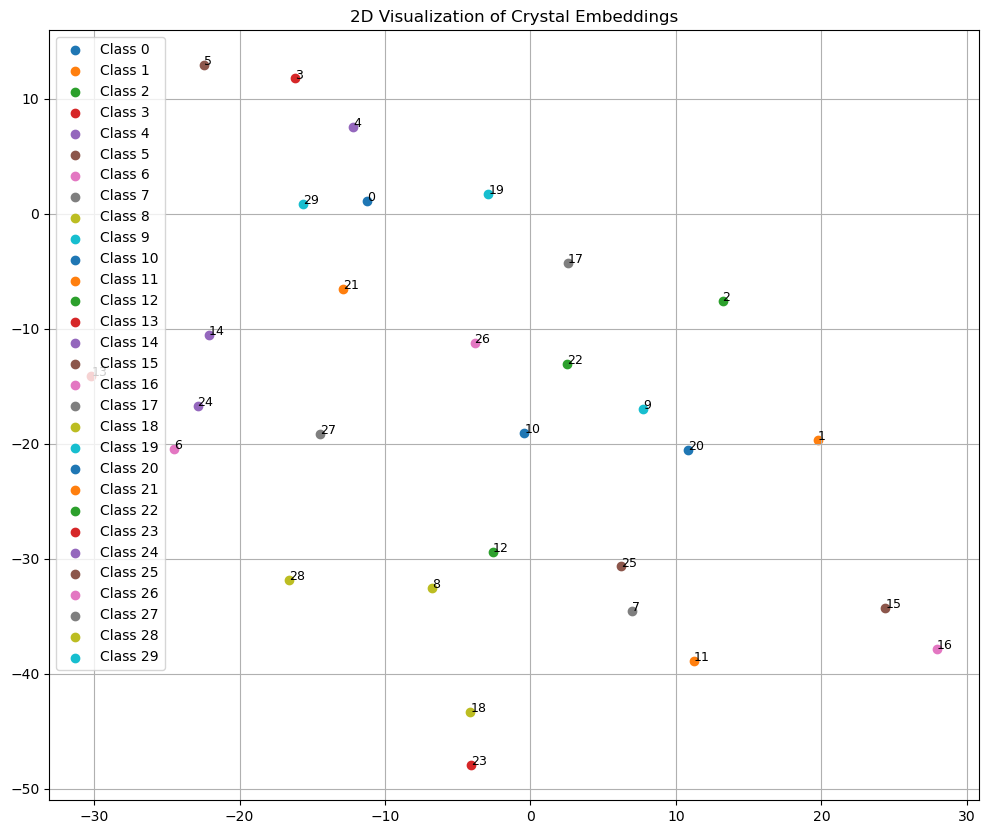

In [36]:
plt.figure(figsize=(12, 10))
plt.title('2D Visualization of Crystal Embeddings')

# Создаем scatter plot для каждого класса
for class_id, (x, y) in zip(class_ids, embeddings_2d):
    plt.scatter(x, y, label=f'Class {class_id}')
    plt.text(x, y, str(class_id), fontsize=9)

plt.legend()
plt.grid(True)
plt.show()

In [39]:
import plotly.express as px

# Создаем DataFrame для визуализации
import pandas as pd
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'class': [f'Class {cid}' for cid in class_ids],
    'size': [20]*len(class_ids)
})

# Интерактивный scatter plot
fig = px.scatter(df, x='x', y='y', text='class', 
                 hover_name='class', size='size',
                 title='Crystal Structure Embeddings')
fig.update_traces(textposition='top center')
fig.show()